In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.data import get_data, get_run_path, fetching_run
from datasets import PointClouds
import scipy
import matplotlib


In [2]:

def get_idx_chexpert():
    eval_freq = np.concatenate((np.repeat(1, 100), np.repeat(2, 50),
                                    np.repeat(5, 20), np.repeat(10, 20), np.repeat(20, 25),
                                   np.repeat(50, 20), np.repeat(100,40),
                                    np.repeat(200,20), np.repeat(500, 10),
                            np.repeat(500, 60)))
    idx= np.cumsum(eval_freq)
    perc=idx/201055*100
    return idx, perc

def get_chexpert_path(args):
    path_root= f"/Users/victoriabarenne/{args.run}/{args.dataset}"
    if args.algorithm =="adpc":
        run_path= f"{path_root}/1000_4_{args.tsh}_{args.hard_thresholding}_gamma{args.gamma}_{args.reduction_method}_{args.sd}/"
    elif args.algorithm in ["benchmark", "random", "full"]:
        run_path= f"{path_root}/1000_{args.sd}/"
    elif args.algorithm == "pc":
        run_path= f"{path_root}/1000_{args.tsh}_{args.sd}/"
    elif args.algorithm == "coverpc":
        run_path= f"{path_root}/1000_4_{args.tsh}_{args.hard_thresholding}_eps{args.eps}_cover{args.cover_threshold}_{args.sd}/"
    return run_path

def get_chexpert_scores(args, method, n_seeds=5):
    assert (method in ["1_NN", "5_NN", "20_NN", "100_NN", "5_NN_continuous", "20_NN_continuous", "100_NN_continuous", "mlp"])
    if args.algorithm=="full":
        scores_aggregated= np.empty((n_seeds,))
    else:
        scores_aggregated= np.empty((365, n_seeds))

    for sd in range(n_seeds):
        args.sd= sd+1
        path= get_chexpert_path(args)
        if method=="1_NN":
            if args.algorithm=="full":
                scores= pd.read_csv(path+f"full_auc.csv")["full_auc"].to_numpy()[0]
            else:
                scores= pd.read_csv(path+f"{args.algorithm}_aucs.csv")[f"{args.algorithm}_aucs"].to_numpy()[:365]
        else:
            if args.algorithm=="full":
                scores= pd.read_csv(path+f"evaluation_full.csv", index_col=0)[method].item()
            else:
                scores= pd.read_csv(path+f"evaluation.csv", index_col=0)[method].to_numpy()[:365]
        if args.algorithm=="full":
            scores_aggregated[sd]= scores
        else:
            scores_aggregated[:,sd]= scores

    return scores_aggregated


def get_chexpert_aggregated(args, method, n_seeds=5):
    radiuses = np.empty((201055, 365, n_seeds))
    covers= np.empty((365, n_seeds))
    degrees, options= np.empty((45000, n_seeds)),  np.empty((45000, n_seeds))
    queries= np.empty((45000, n_seeds))
    scores= get_chexpert_scores(args, method, n_seeds=5)
    for sd in range(5):
        args.sd= sd+1
        path= get_chexpert_path(args)
        if args.algorithm!="full":
            query= pd.read_csv(path+f"{args.algorithm}_queries.csv")[f"{args.algorithm}_queries"].to_numpy()
            queries[:,sd]= query[:45000]
        if args.algorithm in ["pc", "coverpc", "adpc"]:
            radius= np.load(path+f"{args.algorithm}_radiuses.npy")
            cover= pd.read_csv(path+f"{args.algorithm}_covers.csv")[f"{args.algorithm}_covers"].to_numpy()
            degree= pd.read_csv(path+f"{args.algorithm}_degrees.csv")[f"{args.algorithm}_degrees"].to_numpy()
            option= pd.read_csv(path+f"{args.algorithm}_degrees.csv")[f"{args.algorithm}_options"].to_numpy()
            radiuses[:,:,sd]= radius
            covers[:,sd]= cover
            degrees[:,sd], options[:,sd]= degree, option
    if args.algorithm not in ["pc", "coverpc", "adpc"]:
        radiuses, degrees, options, covers= 0, 0, 0, 0
        if args.algorithm=="full":
            queries=0

    return scores, queries, radiuses, degrees, options, covers

In [3]:
def get_ci(y, n_seeds, confidence=0.95):
    t_value = scipy.stats.t.ppf((1 + confidence) / 2.0, df=n_seeds - 1)
    sd = np.std(y, axis=-1, ddof=1)
    se = sd / np.sqrt(n_seeds)

    ci_low = y.mean(-1) - t_value * se
    ci_up = y.mean(-1) + t_value * se

    return y.mean(-1), ci_low, ci_up, t_value*se

def add_score_line(args, label, method, n_seeds= 5, color=None, type="scores", confidence=0.95):
    scores, _, _, degrees, options, covers= get_chexpert_aggregated(args, method, n_seeds=n_seeds)
    if type in ["degrees", "options"]:
        y = degrees if type=="degrees" else options
        idx = np.arange(1, len(degrees)+1)
    elif type in ["scores", "covers"]:
        y= scores if type=="scores" else covers
        idx, perc= get_idx_chexpert()

    mean, ci_low, ci_up, _ = get_ci(y, n_seeds=n_seeds, confidence=confidence)

    sns.lineplot(x=idx, y=mean, label= label, color=color, linewidth= 2)
    plt.fill_between(idx, ci_low, ci_up, alpha=0.5, color=color)

In [5]:
args_random= pd.Series({"dataset":"chexpert", "algorithm":"random", "sd":1, "gamma":0.5, "tsh":0.25,
                        "hard_thresholding":False,"run":"chexpert_runs", "eps":0.9,"cover_threshold":0.5, "reduction_method": "pessimistic",
                        })
args_pc95, args_pc75, args_pc50, args_coverpc, args_full, args_adpc= args_random.copy(), args_random.copy(), args_random.copy(), args_random.copy(), args_random.copy(), args_random.copy()
args_pc95.tsh, args_pc75.tsh, args_pc50.tsh= 0.95, 0.75, 0.5
args_pc95.algorithm, args_pc75.algorithm, args_pc50.algorithm= "pc", "pc", "pc"
args_coverpc.algorithm, args_coverpc.tsh= "coverpc", 0.25
args_full.algorithm= "full"
args_adpc.algorithm, args_adpc.tsh, args_adpc.hard_thresholding= "adpc", 0.25, True

In [10]:
for sd in range(5):
    path=f'/Users/victoriabarenne/chexpert_runs/chexpert/1000_4_0.25_True_gamma0.5_pessimistic_{sd+1}/adpc_scores.csv'
    a= pd.read_csv(path, index_col=0)["adpc_scores"].to_numpy()
    print(a.shape)

(291,)
(301,)
(301,)
(301,)
(296,)


In [15]:
idx, _= get_idx_chexpert()
idx[291]

9400

In [162]:
method= "1_NN"
type="covers"
cmap=matplotlib.colormaps["Set2"].colors
save= True
arguments= [args_pc75, args_pc50, args_pc95, args_coverpc ]
labels= ["PC with 0.75 purity threshold ","PC with 0.5 purity threshold ", "PC with 0.95 purity threshold ","DynamicPC"]

location = {"scores": "lower right",
    "covers": "upper left",
    "degrees": "upper right",
    "options": "upper left"}
ylabel= {"scores": "Accuracy",
          "covers": "Coverage",
         "degrees": "Out degree of the selected query",
         "options": "Number of options with same out degree"}

for method in ["1_NN", "5_NN", "20_NN", "100_NN", "5_NN_continuous", "20_NN_continuous", "100_NN_continuous", "mlp"]:
    c=1
    for i, arg in enumerate(arguments):
        add_score_line(arg, labels[i], method, n_seeds=5, color= cmap[c], type=type, confidence=0.95)
        c+=1
    if type=="scores":
        add_score_line(args_random, "Random", method, n_seeds= 5, color=cmap[-2], type=type, confidence=0.95)
        add_score_line(args_full, "Oracle", method, n_seeds= 5, color=cmap[-1], type=type, confidence=0.95)
    if type in ["scores", "covers"]:
        plt.xscale("log")
    plt.legend(loc= location[type])
    plt.xlabel("Number of queries")
    plt.ylabel(ylabel[type])
    if type=="scores":
        xlim={"1_NN":0, "5_NN":5, "20_NN":20, "100_NN":100, "5_NN_continuous":5, "20_NN_continuous":20, "100_NN_continuous":100, "mlp":0}
        plt.xlim(xlim[method])
    elif type=="degrees":
        plt.ylim(0,30)
    elif type=="options":
        plt.ylim(0)

    if save:
        plt.savefig(f"/Users/victoriabarenne/thesis_plots/chexpert/{method}_{type}.png")
        plt.close()
    else:
        plt.show()



PC (0.6769086122512817, 0.6950682401657104, 0.7051015853881836, 0.7108540773391724)
Random (0.6809532642364502, 0.6932577013969421, 0.7037770628929139, 0.7122783303260803)
PC (0.5828511759999999, 0.5891953799999999, 0.5961023300000001, 0.6007154459999999)
Random (0.576945354, 0.582859968, 0.58976764, 0.595852128)
PC (0.614143376, 0.62318643, 0.6333217939999999, 0.638806276)
Random (0.610816796, 0.6207455420000001, 0.630023618, 0.6367172780000001)
PC (0.631796128, 0.6424626840000001, 0.6540724560000001, 0.662048248)
Random (0.632540426, 0.64400809, 0.65584665, 0.663144226)
PC (0.5372525899999999, 0.540714714, 0.5454057480000001, 0.54755183)
Random (0.53352736, 0.536930632, 0.5393184120000001, 0.5434826779999999)


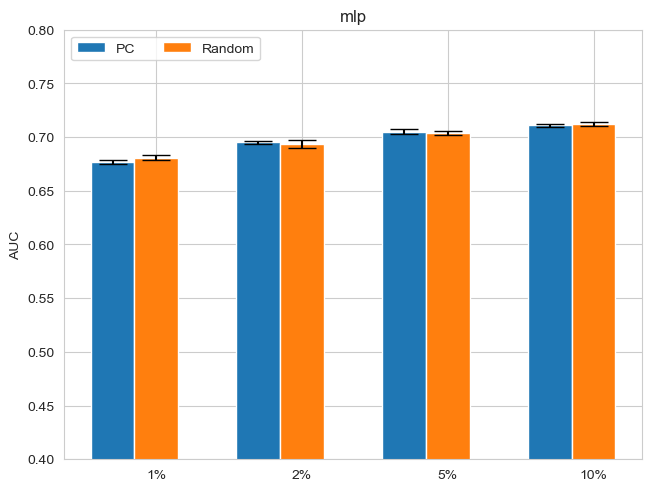

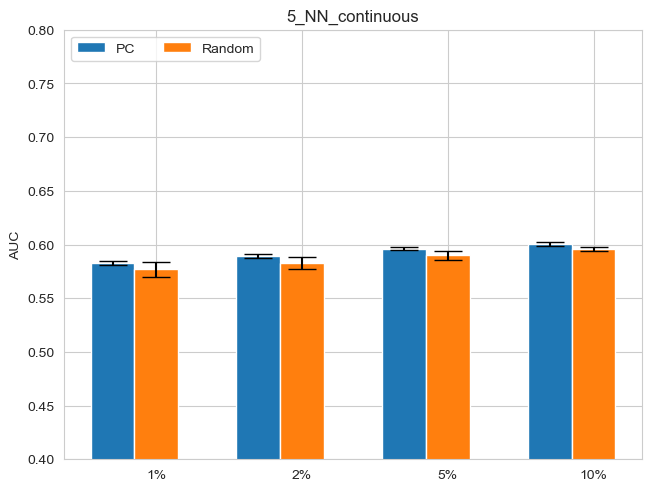

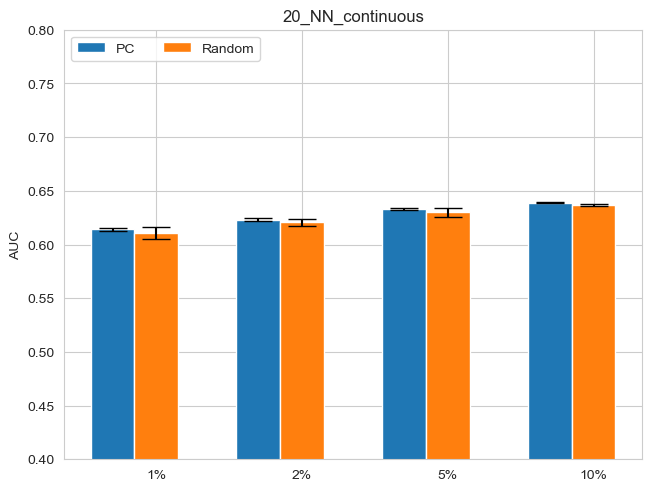

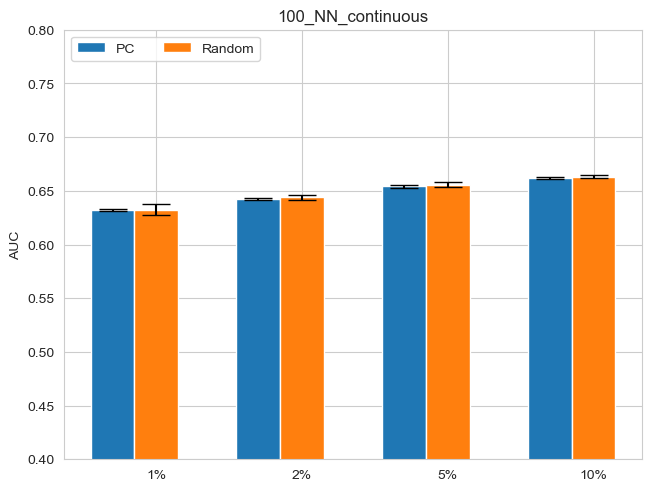

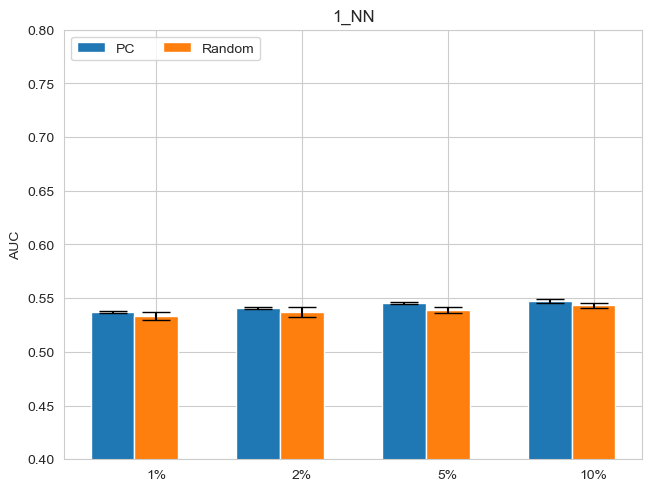

In [36]:
for col in ["mlp", "5_NN_continuous", "20_NN_continuous", "100_NN_continuous", "1_NN"]:
    col_aggregate_pc= np.empty(shape= (325,0))
    col_aggregate_random= np.empty(shape= (325,0))
    for sd in range(1, 6):
        #PC
        pc_path= root+f"1000_0.95_{sd}/"
        evaluation_pc= pd.read_csv(pc_path+"evaluation.csv", index_col=0)
        evaluation1NN= pd.read_csv(pc_path+"pc_aucs.csv", index_col=0)
        evaluation_pc["1_NN"]= evaluation1NN["pc_aucs"]
        col_aggregate_pc= np.concatenate((col_aggregate_pc, evaluation_pc[f"{col}"].to_numpy().reshape(-1,1)),axis=1)
        #RANDOM
        random_path= root+f"1000_{sd}/"
        evaluation_random= pd.read_csv(random_path+"evaluation.csv", index_col=0)
        evaluation1NN= pd.read_csv(random_path+"random_aucs.csv", index_col=0)
        evaluation_random["1_NN"]= evaluation1NN["random_aucs"]
        col_aggregate_random= np.concatenate((col_aggregate_random, evaluation_random[f"{col}"].to_numpy().reshape(-1,1)),axis=1)

    pc_mean= col_aggregate_pc.mean(-1)
    random_mean= col_aggregate_random.mean(-1)
    pc_std= col_aggregate_pc.std(-1)
    random_std= col_aggregate_random.std(-1)

    species = ("1%", "2%", "5%", "10%")
    means = {
        'PC': (pc_mean[234], pc_mean[254], pc_mean[294], pc_mean[314]),
        'Random': (random_mean[234], random_mean[254], random_mean[294], random_mean[314]),
    }

    stds = {
        'PC': (pc_std[234], pc_std[254], pc_std[294], pc_std[314]),
        'Random': (random_std[234], random_std[254], random_std[294], random_std[314]),
    }


    x = np.arange(len(species))  # the label locations
    width = 0.3  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurement in means.items():
        print(attribute, measurement)
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, yerr= stds[attribute], label=attribute,
                       capsize=10)
        # ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('AUC')
    ax.set_title(f'{col}')
    ax.set_xticks(x + width, species)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0.4, 0.8)

